# Titanic - Machine Learning from Disaster

Dataset Description
Overview

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV


import warnings
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)

## 1: Data Loading and Concatenation

In [2]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Add source identifier
train['Source'] = 'train'
test['Source'] = 'test'

# Add Survived to test with NaN to maintain structure
test['Survived'] = np.nan

# Concatenate datasets
df = pd.concat([train, test], ignore_index=True, sort=False)

# Verify sizes
print(f"Original train: {len(train)} records")
print(f"Original test: {len(test)} records")
print(f"Combined data: {len(df)} records")

Original train: 891 records
Original test: 418 records
Combined data: 1309 records


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
print(df.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Source            0
dtype: int64


## 2: Exploratory Data Analysis (EDA)

### 2.1. Univariate *Analysis*

#### Numerical Variables

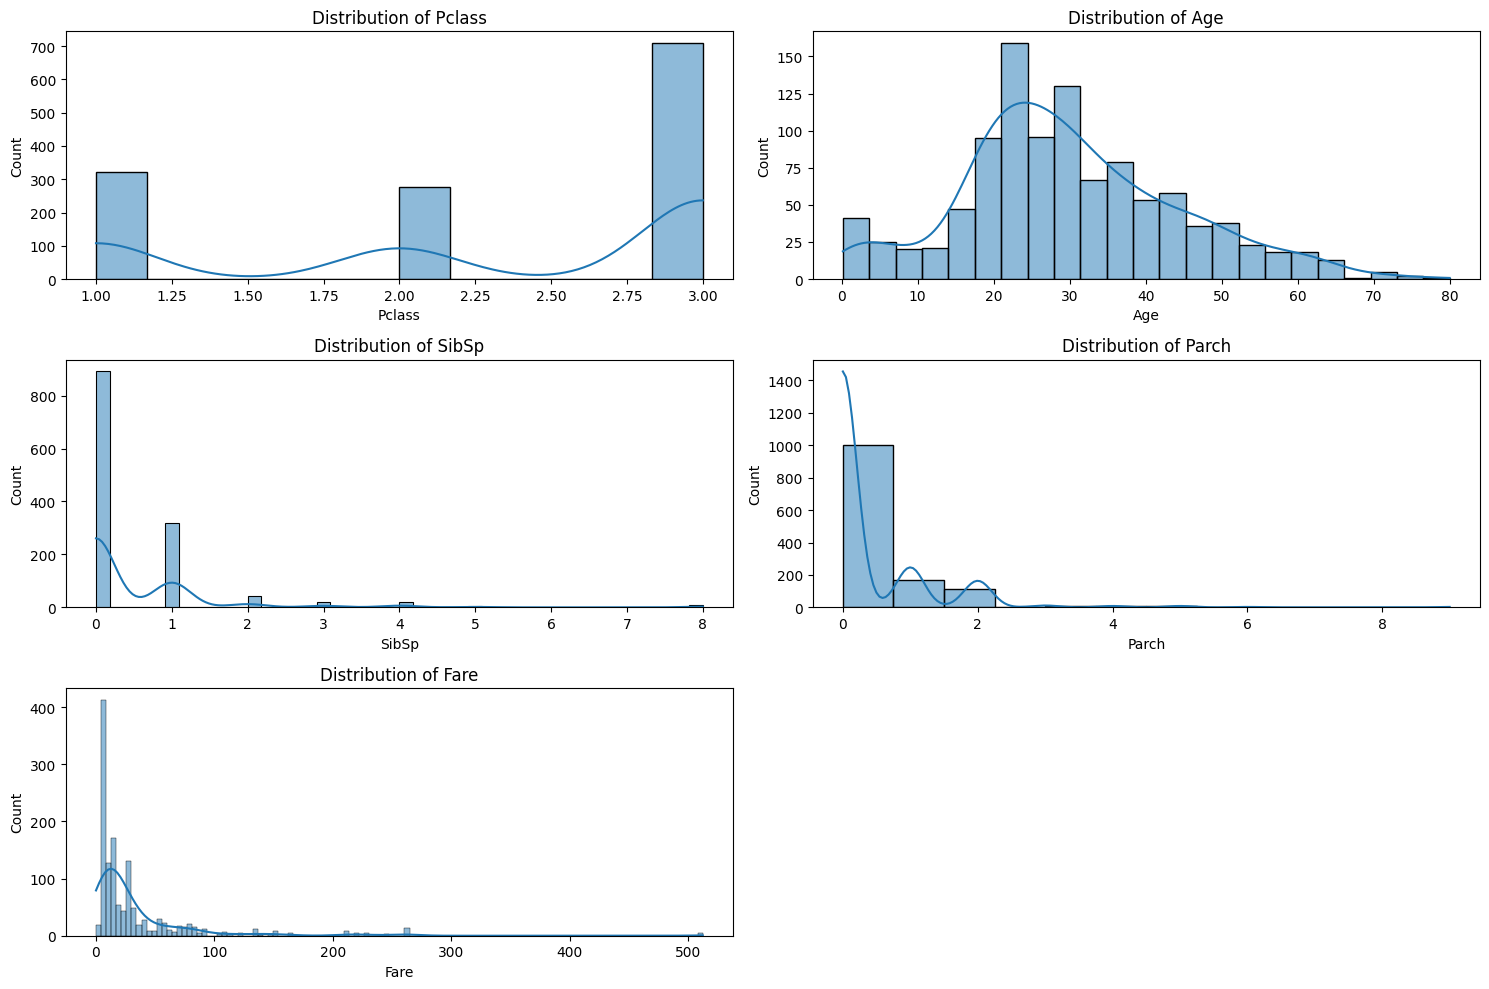

In [6]:
# Histograms and boxplots for numerical variables
num_vars = df.select_dtypes(include=np.number).columns.tolist()
num_vars.remove('PassengerId')
num_vars.remove('Survived')

plt.figure(figsize=(15, 10))
for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=var, kde=True)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

#### Categorical Variables

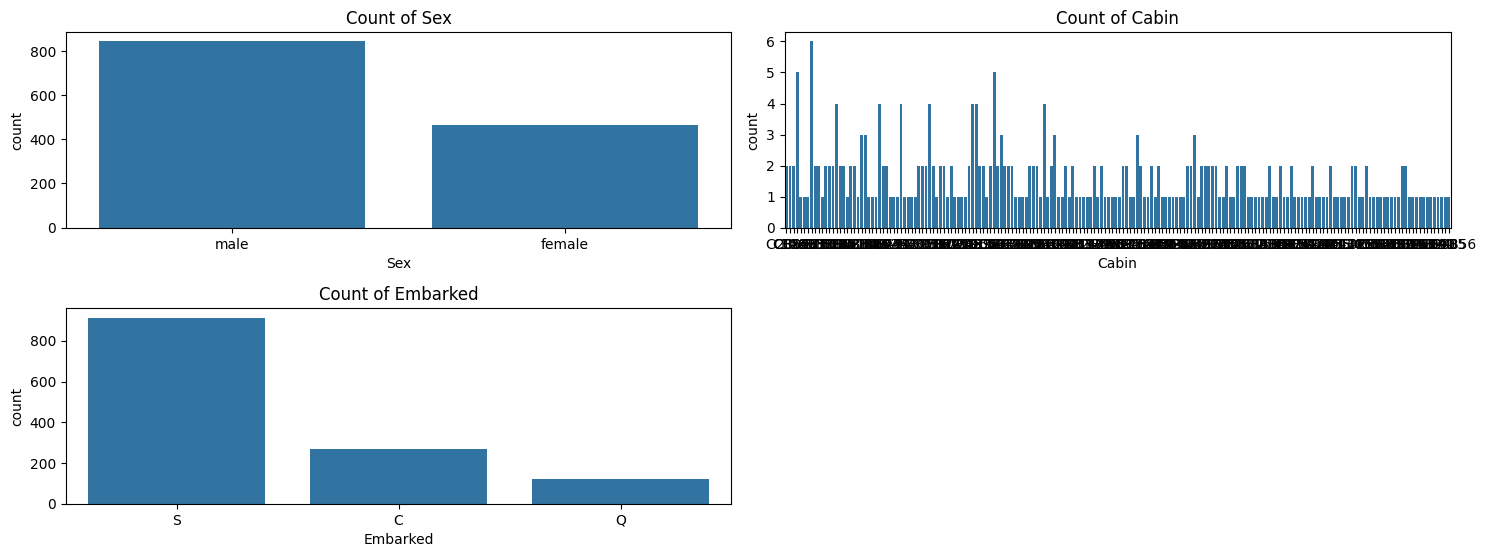

In [7]:
cat_vars = df.select_dtypes(include='object').columns.tolist()
cat_vars.remove('Name')
cat_vars.remove('Ticket')
cat_vars.remove('Source')

plt.figure(figsize=(15, 8))
for i, var in enumerate(cat_vars, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=var)
    plt.title(f'Count of {var}')
plt.tight_layout()
plt.show()

### 2.2. Bivariate *Analysis*

#### Numerical vs. Numerical


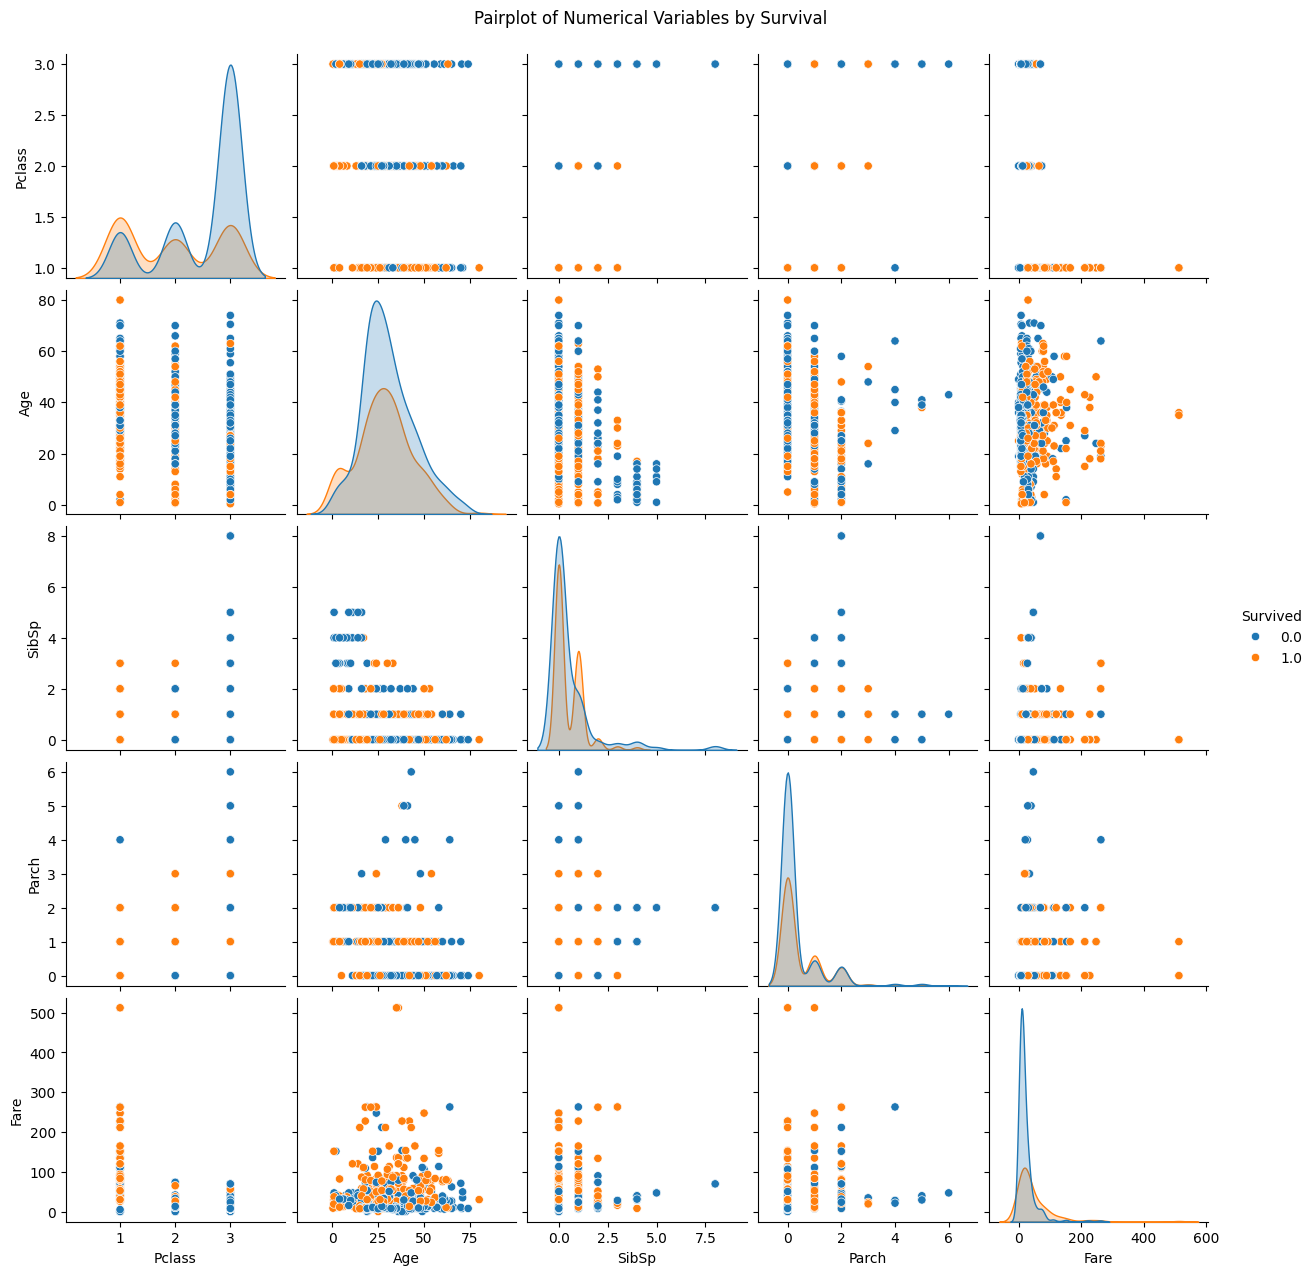

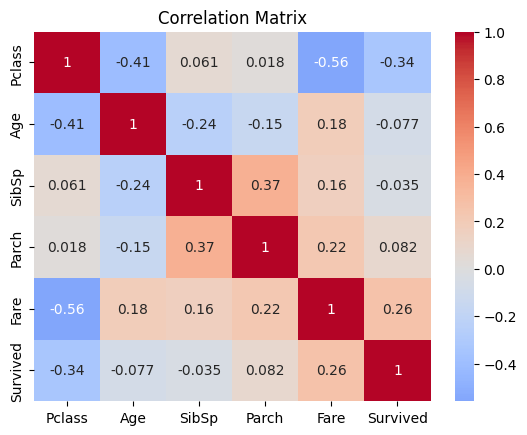

In [8]:
# Pairplot and correlation matrix
sns.pairplot(df[num_vars + ['Survived']], hue='Survived')
plt.suptitle('Pairplot of Numerical Variables by Survival', y=1.02)
plt.show()

corr = df[num_vars + ['Survived']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

#### Numerical vs. Categorical (Target = Survived)


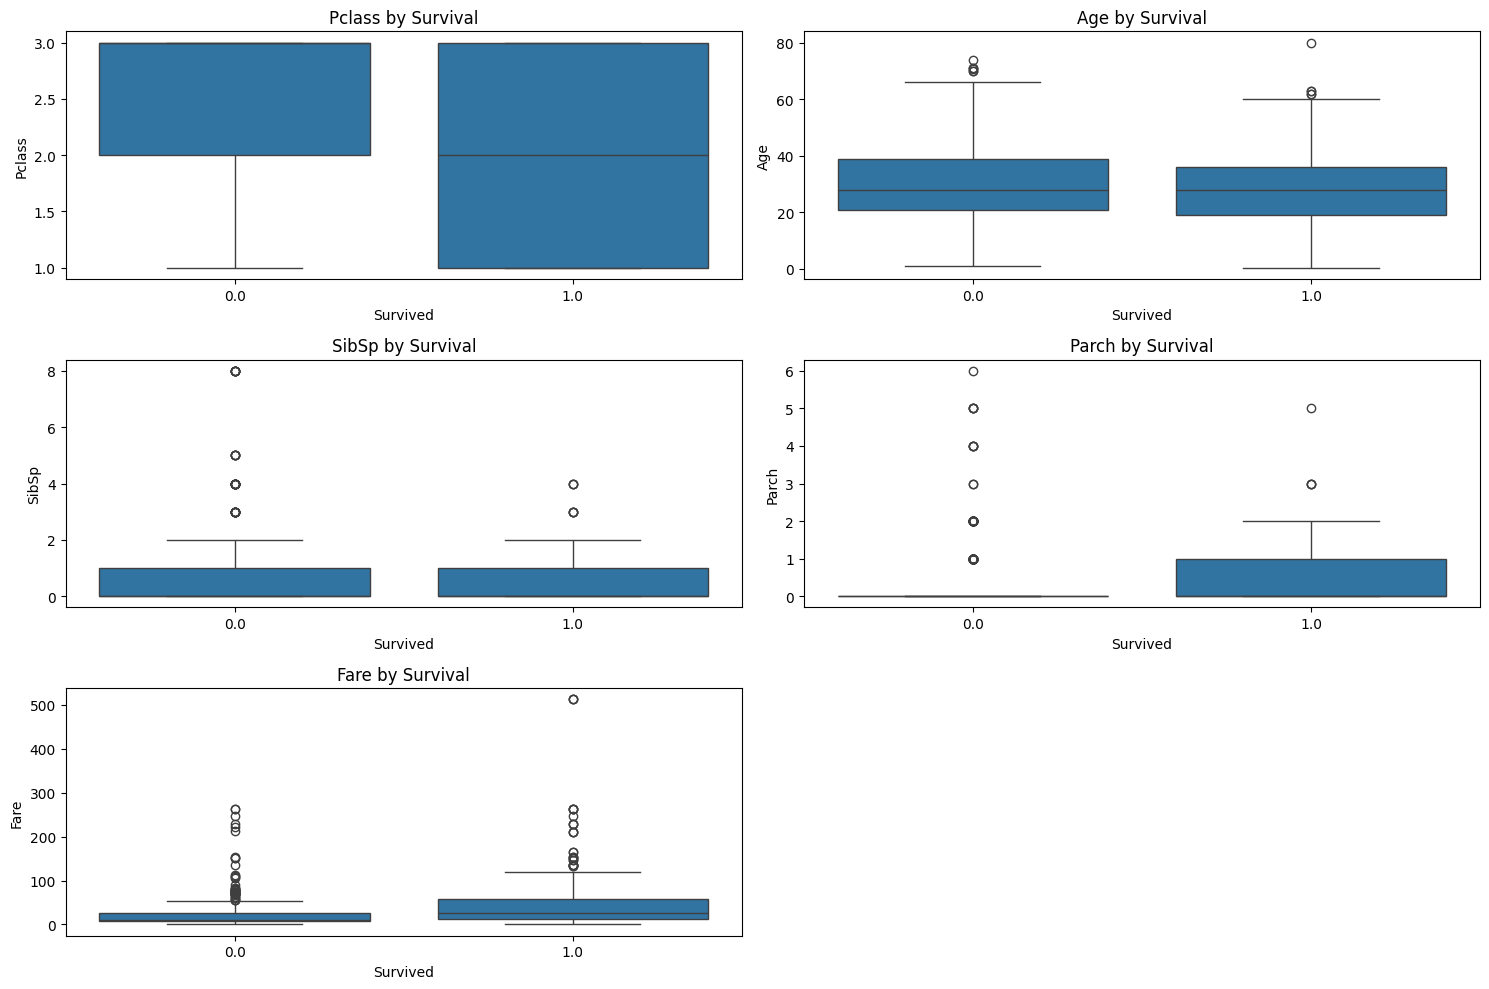

In [9]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(num_vars, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, y=var, x='Survived')
    plt.title(f'{var} by Survival')
plt.tight_layout()
plt.show()

#### Categorical vs. Categorical


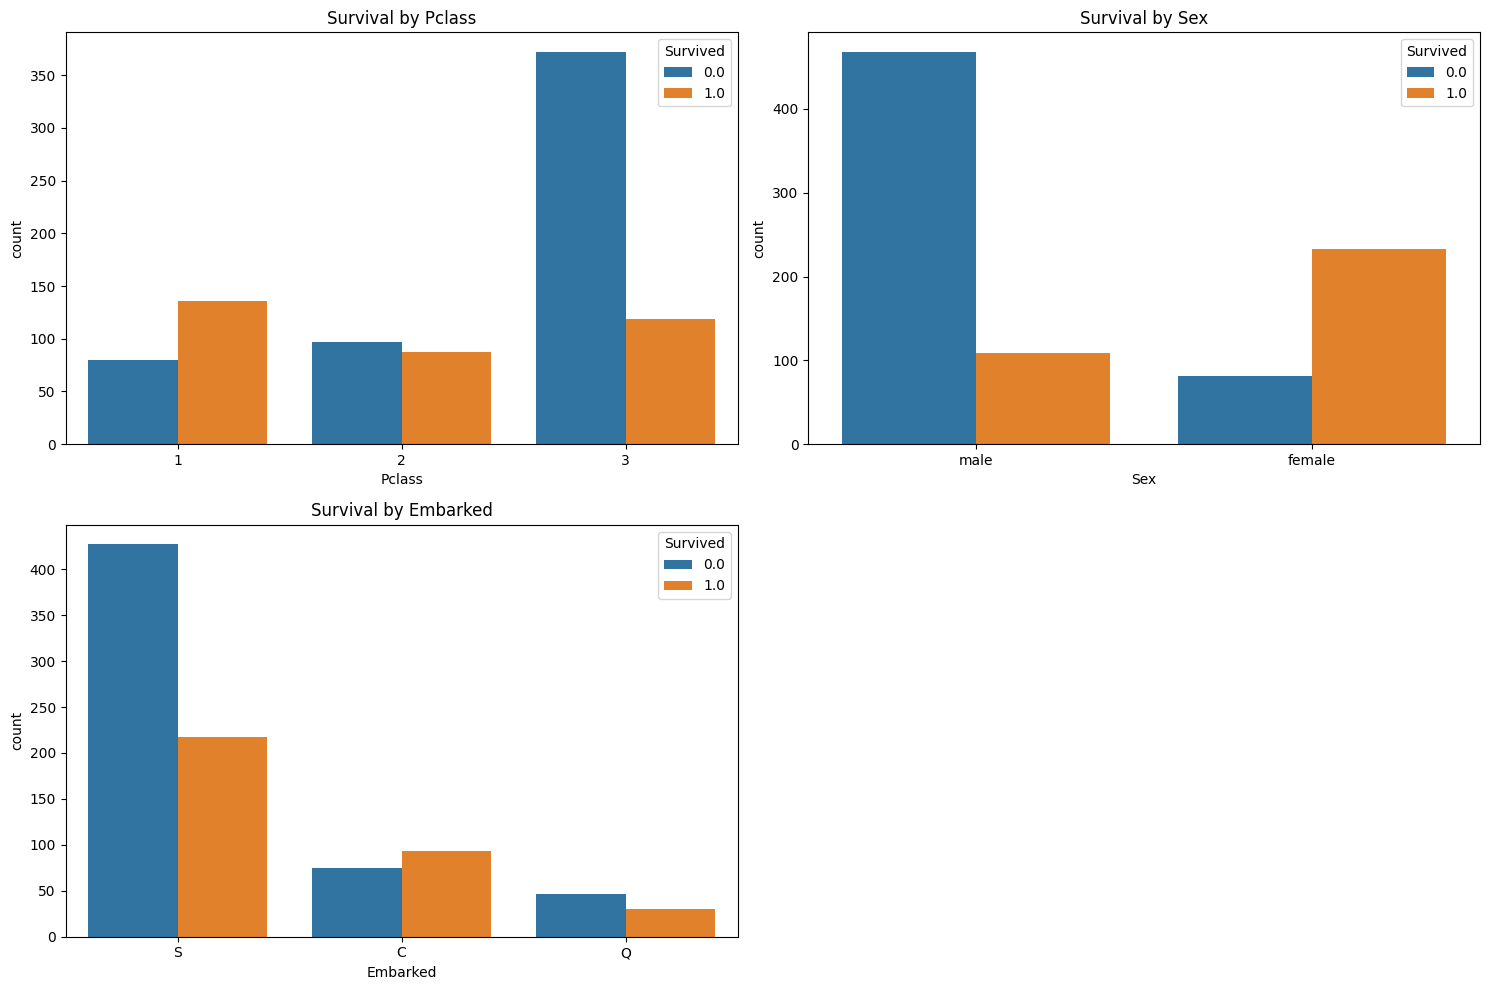

In [10]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(['Pclass', 'Sex', 'Embarked'], 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=var, hue='Survived')
    plt.title(f'Survival by {var}')
plt.tight_layout()
plt.show()

## 3. Feature Engineering & Preprocessing

### 3.1. New Features


In [11]:
# Family features

# Title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Family size and IsAlone
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Cabin presence
df['HasCabin'] = df['Cabin'].notnull().astype(int)

In [12]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source,Title,FamilySize,IsAlone,HasCabin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,Mr,2,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,Mrs,2,0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,Miss,1,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,Mrs,2,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,Mr,1,1,0


### 3.2. Handling Missing Values


In [13]:
# Age: KNNImputer (20% missing)
df['Age'] = KNNImputer(n_neighbors=5).fit_transform(df[['Age']])

# Fare: Fill with median (few missing)
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Age and Fare binning
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 50, 65, 100], labels=False)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=False)

# Fill missing Embarked
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


### 3.3. Encoding Categorical Features

In [14]:
# Ordinal encoding for Pclass
#df['Pclass'] = OrdinalEncoder().fit_transform(df[['Pclass']])

# Label Encoding for Sex, Embarked and Title
cols_to_encode = ['Sex', 'Embarked', 'Title']
le = LabelEncoder()
for col in cols_to_encode:
    df[col] = le.fit_transform(df[col])

### 3.4. Scaling Numerical Features


In [15]:
# RobustScaler (handles outliers)
# num_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
# df[num_cols] = RobustScaler().fit_transform(df[num_cols])

### 3.5. Prepare Datasets

In [16]:
features = ['Pclass', 'Sex', 'AgeBin', 'FareBin', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'HasCabin']

X = df.loc[~df['Survived'].isna(), features]
y = df.loc[~df['Survived'].isna(), 'Survived'].astype(int)
X_test = df.loc[df['Survived'].isna(), features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
X_train.head()

,Pclass,Sex,AgeBin,FareBin,Embarked,Title,FamilySize,IsAlone,HasCabin
331,1,1,3,2,2,2,1,1,1
733,2,1,2,1,2,2,1,1,0
382,3,1,2,1,2,2,1,1,0
704,3,1,2,0,2,2,2,0,0
813,3,0,0,2,2,1,7,0,0


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Pclass      712 non-null    int64
 1   Sex         712 non-null    int64
 2   AgeBin      712 non-null    int64
 3   FareBin     712 non-null    int64
 4   Embarked    712 non-null    int64
 5   Title       712 non-null    int64
 6   FamilySize  712 non-null    int64
 7   IsAlone     712 non-null    int64
 8   HasCabin    712 non-null    int64
dtypes: int64(9)
memory usage: 55.6 KB


## 4. Model Training

### 4.1. Define models and grids params

In [19]:
models_and_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [4, 6, 8],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'bootstrap': [True]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'SVC': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
}

best_score = 0
best_model_name = None
best_model = None
best_params = None

### 4.2. GridSearch for each model

In [20]:
for name, mp in models_and_params.items():
    print(f"\n🔍 Ejecutando GridSearchCV para {name}...")
    gs = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='f1', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print(f"✅ Mejor F1 para {name}: {gs.best_score_:.4f}")
    print(f"📌 Mejores parámetros: {gs.best_params_}")

    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_model_name = name
        best_model = gs.best_estimator_
        best_params = gs.best_params_


🔍 Ejecutando GridSearchCV para RandomForest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✅ Mejor F1 para RandomForest: 0.7554
📌 Mejores parámetros: {'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Ejecutando GridSearchCV para LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Mejor F1 para LogisticRegression: 0.7286
📌 Mejores parámetros: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}

🔍 Ejecutando GridSearchCV para SVC...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Mejor F1 para SVC: 0.7538
📌 Mejores parámetros: {'C': 1, 'kernel': 'rbf'}


### 4.3. Train and Evaluate

In [21]:
print("\n🎯 ==== Mejor modelo encontrado ====")
print(f"Modelo: {best_model_name}")
print(f"F1 Score (CV): {best_score:.4f}")
print(f"Parámetros: {best_params}")

best_model.fit(X_train, y_train)

y_val_pred = best_model.predict(X_val)

print("\n📊 Evaluación en conjunto de validación:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"F1 Score: {f1_score(y_val, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))



🎯 ==== Mejor modelo encontrado ====
Modelo: RandomForest
F1 Score (CV): 0.7554
Parámetros: {'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

📊 Evaluación en conjunto de validación:
Accuracy: 0.8101
F1 Score: 0.7571
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### 4.4. Evaluate on validation set

In [22]:
y_test_pred = best_model.predict(X_test)

print("\n🎯 ==== Predicciones en conjunto de prueba ====")
print(f"Modelo: {best_model_name}")
print(f"Parámetros: {best_params}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))



🎯 ==== Predicciones en conjunto de prueba ====
Modelo: RandomForest
Parámetros: {'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



### 4.5. Create submission file

In [23]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_test_pred.astype(int)
})

submission.to_csv('submission.csv', index=False)
print("✅ Archivo 'submission.csv' creado con las predicciones del mejor modelo.")

✅ Archivo 'submission.csv' creado con las predicciones del mejor modelo.
